In [1]:
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"

2.3.1+cu121
12.1


In [2]:
# version should match with torch and cuda
%%bash
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-cluster -f https://data.pyg.org/whl/torch-2.3.0+cu121.html
pip install torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 84.0 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 63.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 22.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.3.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 947.1/947.1 kB 8.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

import sys
sys.path.append('/content/drive/MyDrive/Dissertation/DissertationData/DeepAR_File')
from Helper import save_intoCSV
from DeepAR import DeepAR, loss_deepAR

In [34]:
def calculate_rmsse(y_true, y_pred, train_data):
    n = len(y_true)
    squared_errors = np.square(y_true - y_pred)
    mean_squared_error = np.mean(squared_errors)
    mean_train_data = np.mean(train_data)
    squared_train_data = np.square(train_data - mean_train_data)
    rmsse = np.sqrt(mean_squared_error / (np.sum(squared_train_data) / (n - 1)))
    return rmsse

# 修正的RMSSE計算函數，加入epsilon以避免除零錯誤
def rmsse(preds, true, train, epsilon=1e-10):
    n = len(true)
    squared_errors = np.square(preds - true)
    mean_squared_errors = np.mean(squared_errors)
    mean_squared_train = np.mean(np.square(train[:-1] - train[1:]))
    return np.sqrt(mean_squared_errors / (mean_squared_train + epsilon))

In [32]:
# 定義 WRMSSE 計算函數
def calculate_wrmsse(y_true, y_pred, y_train, weights=None):
    # 計算 S 均方誤差（MSE）
    mse = np.mean((y_true - y_pred) ** 2, axis=0)

    # 計算平均絕對誤差（MAE）
    mae = np.mean(np.abs(y_true - y_pred), axis=0)

    # 計算 RMSSE
    denominator = np.mean(np.diff(y_train, axis=0) ** 2, axis=0)
    rmsse = np.sqrt(mse / denominator)

    # 計算加權 RMSSE（如果權重存在）
    if weights is not None:
        wrmsse = np.sum(weights * rmsse)
    else:
        wrmsse = np.mean(rmsse)

    return wrmsse

In [9]:
# 1. 讀取和預處理數據
data = pd.read_csv('/content/drive/MyDrive/Dissertation/DissertationData/hobbies.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5650 entries, 0 to 5649
Columns: 1941 entries, d_1 to d_1941
dtypes: int64(1941)
memory usage: 83.7 MB


In [10]:
data['mean_sales'] = data.mean(axis=1)

In [11]:
# 假設 `id` 是商品ID，d_1 到 d_1941 是每天的銷售數據
time_columns = [col for col in data.columns if col.startswith('d_')]

# 將數據轉換為 (樣本數, 時間步長, 特徵數) 的格式
X = data[time_columns].values
X = X.reshape(X.shape[0], -1, 1)  # 這裡特徵數為 1，即每天的銷售數據

# 將目標變量（例如最後一天的銷售量）設為y
y = data['mean_sales'].values  # 假設 'mean_sales' 是你要預測的目標

# 檢查重塑後的數據
print("X shape:", X.shape)  # 應該是 (商品數, 1941, 1)
print("y shape:", y.shape)  # 應該是 (商品數,)

X shape: (5650, 1941, 1)
y shape: (5650,)


In [12]:
# 先將資料分割為訓練+驗證集和測試集 (80/20)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 再將訓練+驗證集分割為訓練集和驗證集 (80/20)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

In [13]:
# 將數據轉換為 PyTorch 的 DataLoader 格式
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                               torch.tensor(y_train, dtype=torch.float32))
val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                                             torch.tensor(y_val, dtype=torch.float32))
test_dataset = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                              torch.tensor(y_test, dtype=torch.float32))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

In [14]:
# 設置設備
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 模型參數設置
input_size = X_train.shape[2]  # 特徵數
encoder_len = 1  # 使用過去7天的數據來預測
decoder_len = 1  # 預測1天

# 初始化模型
model = DeepAR(input_size=input_size, device=device, encoder_len=encoder_len, decoder_len=decoder_len,
               hidden_size=20, num_layers=3, dropout=0.3)
model.to(device)

DeepAR(
  (encoder): LSTM(1, 20, num_layers=3, batch_first=True, dropout=0.3)
  (decoder): LSTM(1, 20, num_layers=3, batch_first=True, dropout=0.3)
  (squeeze_layers_mu): Linear(in_features=3, out_features=1, bias=True)
  (squeeze_layers_sig): Linear(in_features=3, out_features=1, bias=True)
  (probability_mean): Linear(in_features=20, out_features=1, bias=True)
  (probability_std): Linear(in_features=20, out_features=1, bias=True)
  (std_softplus): Softplus(beta=1.0, threshold=20.0)
)

In [15]:
# 設置損失函數和優化器
criterion = loss_deepAR
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
# 訓練模型
epochs = 100
train_losses = []
val_losses = []
rmsse_scores = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 調整 y_batch 的形狀
        if len(y_batch.shape) == 1:  # 處理 [batch_size] 的情況
            y_batch = y_batch.unsqueeze(1)  # [batch_size, 1]
        if len(y_batch.shape) == 2:  # 處理 [batch_size, decoder_len] 的情況
            y_batch = y_batch.unsqueeze(2)  # [batch_size, decoder_len, 1]

        optimizer.zero_grad()
        outputs, mu, sigma, _, _ = model(X_batch, y_batch)
        loss = criterion(mu, sigma, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # 驗證集
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            if len(y_batch.shape) == 1:
                y_batch = y_batch.unsqueeze(1)
            if len(y_batch.shape) == 2:
                y_batch = y_batch.unsqueeze(2)

            outputs, mu, sigma, _, _ = model(X_batch, y_batch)
            val_loss = criterion(mu, sigma, y_batch)
            val_running_loss += val_loss.item()

    val_losses.append(val_running_loss / len(val_loader))

    # 計算 RMSSE
    y_val_pred = []
    with torch.no_grad():
        for X_batch, _ in val_loader:
            X_batch = X_batch.to(device)
            outputs, mu, sigma, _, _ = model(X_batch, X_batch[:, -1:, :])
            y_val_pred.append(mu.cpu().numpy())
    y_val_pred = np.concatenate(y_val_pred, axis=0)

    rmsse_score = calculate_rmsse(y_val, y_val_pred, y_train)
    #rmsse_score = rmsse(y_val_pred, y_val, y_train)
    rmsse_scores.append(rmsse_score)

    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, RMSSE: {rmsse_score}')

Epoch 1/100, Training Loss: 10.995583527493027, Validation Loss: 11.765225512041173, RMSSE: 0.6817878114204042
Epoch 2/100, Training Loss: 10.526457129784351, Validation Loss: 11.684139659706975, RMSSE: 0.6867692209183336
Epoch 3/100, Training Loss: 10.219702968057597, Validation Loss: 11.544449865818024, RMSSE: 0.6871295843262532
Epoch 4/100, Training Loss: 10.401417763728016, Validation Loss: 11.035034643092626, RMSSE: 0.6876136580902521
Epoch 5/100, Training Loss: 9.653204713227614, Validation Loss: 10.99942424767454, RMSSE: 0.6876985976043853
Epoch 6/100, Training Loss: 10.06763052602984, Validation Loss: 10.865396623880091, RMSSE: 0.691088579488071
Epoch 7/100, Training Loss: 9.68743040201799, Validation Loss: 11.061363937989087, RMSSE: 0.6980014911652381
Epoch 8/100, Training Loss: 9.67535291527802, Validation Loss: 10.320831465049528, RMSSE: 0.7052723866776333
Epoch 9/100, Training Loss: 8.85552333210999, Validation Loss: 10.22362965093532, RMSSE: 0.7071047385306685
Epoch 10/100

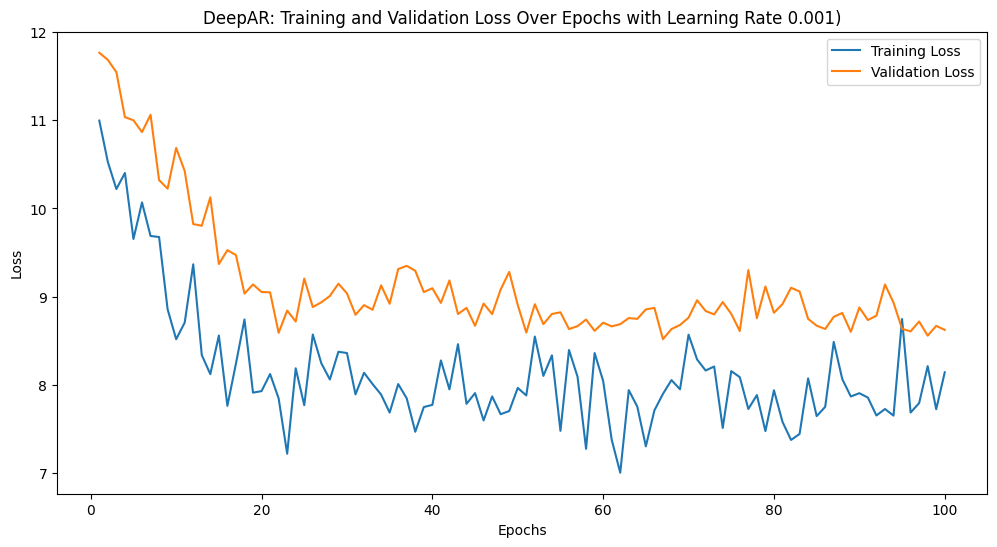

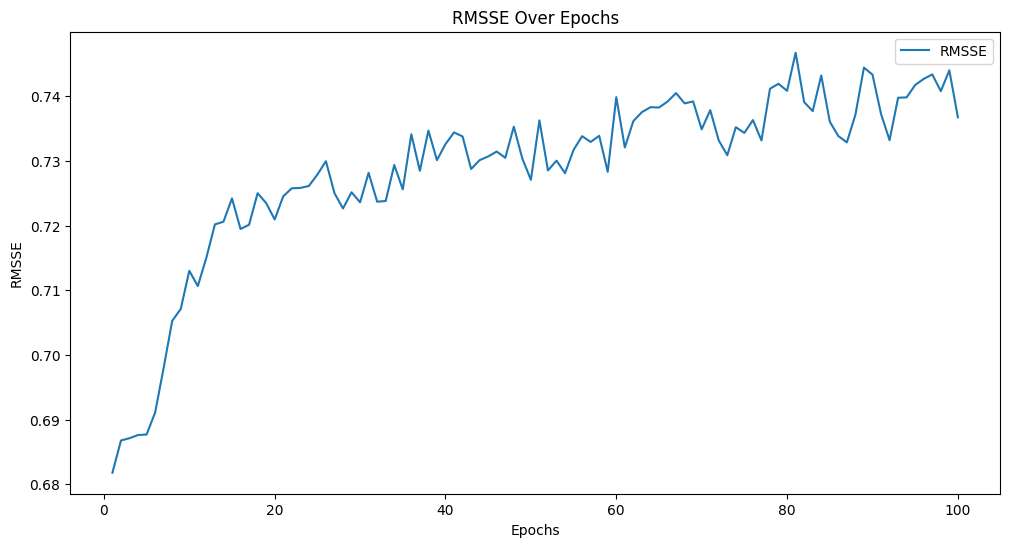

In [19]:
# 繪製訓練和驗證損失曲線
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('DeepAR: Training and Validation Loss Over Epochs with Learning Rate 0.001)')
plt.legend()
plt.show()

# 繪製 RMSSE 曲線
plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), rmsse_scores, label='RMSSE')
plt.xlabel('Epochs')
plt.ylabel('RMSSE')
plt.title('RMSSE Over Epochs')
plt.legend()
plt.show()

In [25]:
# 設定模型為評估模式
model.eval()

# 儲存預測值和真實值
y_test_pred = []
y_test_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 模型預測
        outputs, mu, sigma, _, _ = model(X_batch, X_batch[:, -1:, :])

        # 儲存預測值和真實值
        y_test_pred.append(mu.cpu().numpy())
        y_test_true.append(y_batch.cpu().numpy())

# 將結果拼接為numpy陣列
y_test_pred = np.concatenate(y_test_pred, axis=0)
y_test_true = np.concatenate(y_test_true, axis=0)

In [27]:
# 計算 WRMSSE

wrmsse = calculate_wrmsse(y_test_true, y_test_pred, y_train)
print(f'Test WRMSSE: {wrmsse}')

Test WRMSSE: 0.5478803515434265


In [28]:
# 保存模型
model_save_path = "/content/drive/MyDrive/Dissertation/DissertationData/BestModels/deep_ar_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Dissertation/DissertationData/BestModels/deep_ar_model.pth


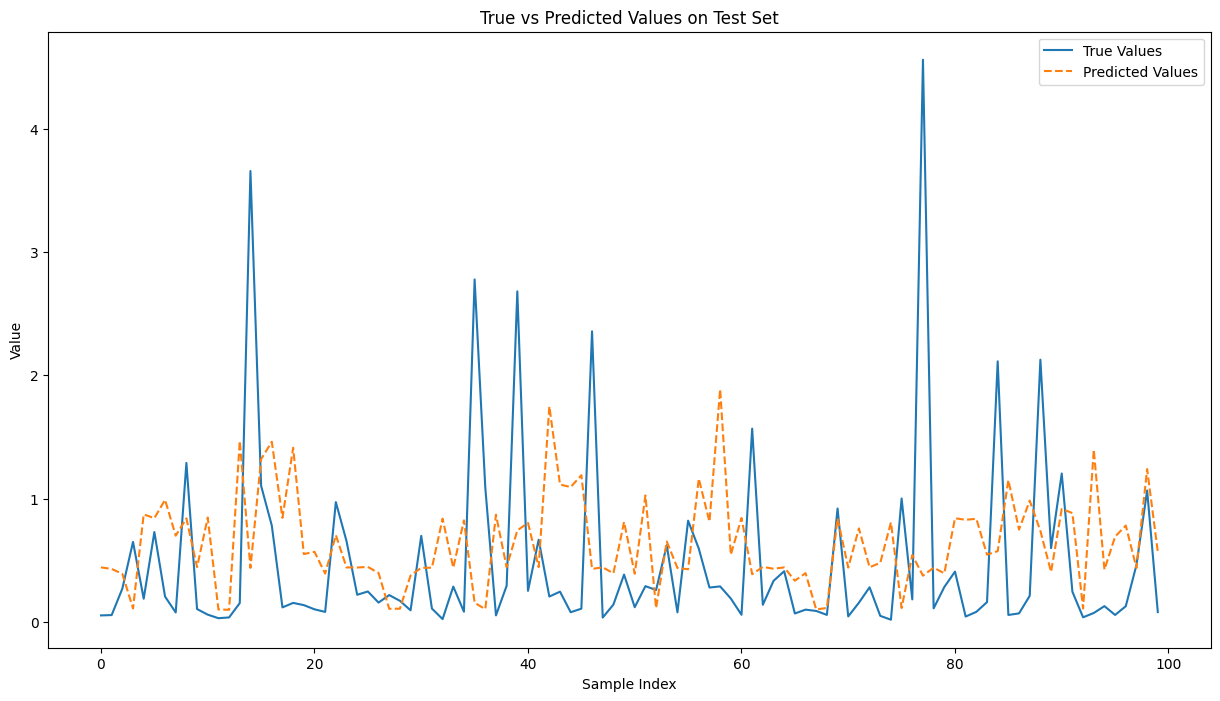

In [30]:
# 選擇一些樣本進行可視化比較
n_samples_to_plot = 100  # 選擇需要展示的樣本數

# 壓縮 y_test_pred，使其形狀與 y_test_true 一致
y_test_pred_squeezed = y_test_pred.squeeze()

plt.figure(figsize=(15, 8))
plt.plot(y_test_true[:n_samples_to_plot], label='True Values')
plt.plot(y_test_pred_squeezed[:n_samples_to_plot], label='Predicted Values', linestyle='dashed')
plt.title('True vs Predicted Values on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()